In [29]:
type(filter_abs_temp)

numpy.ndarray

threshhold =  0.015
threshold =  [ 0.00248476]
width and length =  [[ 34.  34.]]
predicted =  [[ 6525.32922041    92.63234432    95.82219815]]
labeled =  [ 6507.    87.    96.]
Ratio =  [[ 1.00281685  1.06473959  0.9981479 ]]
width and length =  [[ 18.  42.]]
predicted =  [[ 5572.83049863    72.24574159   100.04080327]]
labeled =  [ 5496.    81.   103.]
Ratio =  [[ 1.01397935  0.89192274  0.97126993]]
 clf score : 0.9952666641809473

CV score are [  0.99526666   0.93343991   0.83278819   0.40632367   0.66163374
   0.87018742  -0.06670625   0.99792206   0.92695799   0.87701376
   0.66145462   0.93397614   0.9787469    0.76684778   0.74764989
   0.98707785   0.94355215   0.96835575   0.97656186   0.12391815
   0.97044286   0.98321333   0.34597624   0.93043391   0.40670406
   0.90811897   0.80269603   0.67287106   0.95597615   0.96921039
   0.58686681   0.99603109  -0.71676374   0.18519523   0.43612737
   0.99173136   0.93348388   0.28751151   0.67734375   0.66374006
   0.28165438   0.906

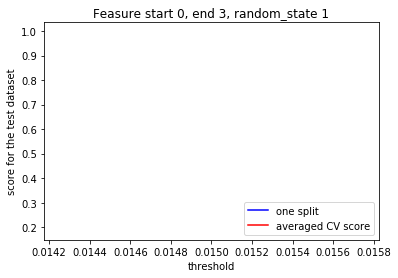

In [85]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage

import os, errno

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# define the width and length arrays 

rect_spc_x=0.001;
rect_spc_y=0.001;

rect_array_x = np.zeros(54)
rect_array_y = np.zeros(54)

for ix in range(54):
    rect_array_x[ix]=(rect_spc_x*(ix+1))/2

for iy in range(54):
    rect_array_y[iy]=(rect_spc_y*(iy+1))/2

    
#plt.plot(range(54),rect_array_x,'.')
#plt.show()





# load, slice, and reshape 2D image into to 1D array 
import sys
sys.path.append('/home/j2/home/j2/ml/env/lib/python3.5/site-packages')
from numpy import unravel_index

feature_star = 0 
feature_end = 3 # not inclusive

import cv2
import argparse

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import ShuffleSplit


flag_plot_gene = 2
xlennum=42
ylennum=42

xrange = range(2,xlennum+1,4)
yrange = range(2,ylennum+1,4)
rect_ixx = np.zeros(len(xrange))
rect_iyy = np.zeros(len(yrange))

image3D = np.zeros((401,401))
image2DLong = np.zeros(((401*401),1))
#image3D = []

clfscorelist = np.zeros(1)
cvscorelist = np.zeros(1)

#tholdmatrix = [0.02]
#tholdmatrix = [0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98]
#tholdmatrix = [0.02,0.05,0.1,0.2,0.3,0.4]
#tholdmatrix = [0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]
tholdmatrix = [0.015]




random_statevalue = 1 

for thold in tholdmatrix:
    print('threshhold = ', thold)
    
    totalIndex = 0 
    directory = '/home/j2/Desktop/PythonTry/MLshm/oput/feature_star%dthold%03d' % (feature_star,thold*100)

    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    nnum = 401 

    kernelx = 15
    kernely = 15
    kernaltotal = kernelx * kernely
    
    kernel = np.ones((kernelx,kernely),np.float32)/kernaltotal
    
    df = pd.read_csv('sumValuesThrhPer20.csv')
    dfXtemp = df[['x (mm)','y (mm)']]
    
    X = np.zeros((1,2))
    Y = np.zeros((1,6))

    
    for ixx in xrange: #range(2,10+1,4):#
        for iyy in yrange: # range(2,6+1,4):#
            rect_ixx = rect_array_x[ixx]
            rect_iyy = rect_array_y[iyy]

            totalIndex += 1 
            Dxmm = int(round(2*rect_ixx*1e3-1))    
            Dymm = int(round(2*rect_iyy*1e3-1))
            
            parafilename = '/home/j2/Desktop/PythonTry/MLshm/MLRTMwithExperiment/rectx%03dy%03d/iter00000/bnzlcc.csv' % (Dxmm,Dymm)
            tempdf = pd.read_csv(parafilename,header=None)


            tempdfabs = abs(tempdf.values)
            filter_abs = cv2.filter2D(tempdfabs,-1,kernel)
            filter_abs_temp = filter_abs
            maxfilter_abs = filter_abs.max().max()
            filter_abs_temp[filter_abs < thold*(dfY[['max value']].max().values)] = 0
            filter_abs_temp[:,:130] = 0


            if flag_plot_gene == 1: 
                imagfilename = '/home/j2/Desktop/PythonTry/MLshm/oput/feature_star%dthold%03d/filter%d.png' % (feature_star,(thold*100),totalIndex)
                fig = plt.figure()
                plt.imshow(ndimage.rotate(filter_abs_temp,90))
                
                plt.title('Dx = %d mm   Dy= %d mm' % (Dxmm,Dymm))
                plt.savefig(imagfilename,format='png', dpi=300)
                #plt.show()
                plt.close()

            LL = np.zeros([nnum,nnum])
            #LL[filter_abs > thold*maxfilter_abs] = 1
            LL[filter_abs > thold*(dfY[['max value']].max().values)] = 1
            

            P_area_num=LL.sum().sum()
            P_width = np.sum(LL,axis=0).max()
            P_length = np.sum(LL,axis=1).max()
            Pxy = unravel_index(filter_abs_temp.argmax(), filter_abs_temp.shape)  
            onerow = np.array([P_area_num,P_width,P_length,Pxy[0],Pxy[1],maxfilter_abs]).reshape((1,6))
            onerowX = np.array([Dxmm,Dymm]).reshape((1,2))
            X = np.append(X,onerowX,axis=0)
            Y = np.append(Y,onerow,axis=0)
            

            #temp = tempdf.values
            #image3D = np.dstack((image3D, temp)) 


            #tempLong= temp.reshape(401*401,1)
            #image2DLong = np.dstack((image2DLong,tempLongrandom_state))

        # get rid of the starting image         
        #imagefinal3D = image3D[:,:,1:]
        #imagefinal2DLong = np.transpose(image2DLong[:,:,1:].reshape(160801,121))

    Yfinal = Y[1:,:]
    Xfinal = X[1:,:]
    X = Xfinal
    colname = ["Area (mm^2)","Length (mm)","Width (mm)","x_center","y_center","max value"]
    dfY = pd.DataFrame(Yfinal, columns=colname)
    file_name ='iput/filterdfYthold%03d.csv' % (thold*100)
    dfY.to_pickle(file_name)
    
    #print(P_area_num,P_width,P_length2,Pxy[0],Pxy[1],maxfilter_abs)
    print('threshold = ',thold*(dfY[['max value']].max().values))

    file_name ='iput/filterdfYthold%03d.csv' % (thold*100)
    dfY = pd.read_pickle(file_name)
    #X=dfX.values
    Y=dfY.values


    # select the first three attributes of the thresholded image: area, width, length 
    Y3 = Y[:,feature_star:feature_end]
 

    X_train, X_test, Y3_train, Y3_test = train_test_split(X, Y3, test_size=0.02, random_state=random_statevalue)
    #print(X_train.shape)
    #print(X_test.shape)
    #print(Y3_train.shape)
    #print(Y3_test.shape)


    from sklearn import linear_model
    # ordinary least squares
    clf = linear_model.LinearRegression()
    # univariate
    clf.fit(X_train,Y3_train)
    clf.score(X_test, Y3_test) 


    def NNpredcheck(x,y,model):
        Yt1 = model.predict(np.array([[x, y]]))
        return Yt1

    textclfscore = ' clf score : ' + np.array_str(clf.score(X_test, Y3_test)) + '\n'
    clfscorestr = np.array_str(clf.score(X_test, Y3_test)) + '\n'
    text35 = 'output (3 5): ' + np.array_str(NNpredcheck(3,5,clf)) + '\n'
    headline = 'feature_star %d thold %d percent  \n' % (feature_star,thold*100)
    #NNpredcheck(3,5,clf)

    outputfilename ='oput/NN3parafeature_star%dthold%03d.csv' % (feature_star,thold*100)

    with open(outputfilename, "w") as f:
        f.write(headline)
        f.write(textclfscore)
        f.write(clfscorestr)
        f.write(text35)


    #indexnumber = 1
    f= open(outputfilename,"a+")
    for irad in range(2):
        indexnumber = irad
        #print('index number is =', indexnumber)
        str1 =  'width and length = ' + np.array_str(X_test[indexnumber,:].reshape(1,-1)) +'\n'
        f.write(str1)
        print('width and length = ', X_test[indexnumber,:].reshape(1,-1) )
        str1 =  'predicted = ' + np.array_str(clf.predict(X_test[indexnumber,:].reshape(1,-1))) +'\n'
        f.write(str1)
        print('predicted = ', clf.predict(X_test[indexnumber,:].reshape(1,-1) ))
        str1 =  'labeled = ' + np.array_str(Y3_test[indexnumber,:]) +'\n'
        f.write(str1)
        print('labeled = ', Y3_test[indexnumber,:])
        str1 = 'Ratio = ' + np.array_str(clf.predict(X_test[indexnumber,:].reshape(1,-1) )/Y3_test[indexnumber,:]) + '\n'
        f.write(str1)
        print('Ratio = ', clf.predict(X_test[indexnumber,:].reshape(1,-1) )/Y3_test[indexnumber,:]) 

    f.close()
    
    print(textclfscore)
    cv = ShuffleSplit(n_splits=121, test_size=0.02, random_state=random_statevalue)
    cvscores = cross_val_score(clf, X, Y3, cv=cv)
    #cvscores = cross_val_score(clf, X, Y3, cv=60)
    print('CV score are', cvscores)
    print('Mean of cv_scores are', cvscores.mean())
    
    #textclfscore
    Y = np.append(Y,onerow,axis=0)
    
    clfscorelist = np.append(clfscorelist,clf.score(X_test, Y3_test)) 
    cvscorelist = np.append(cvscorelist,cvscores.mean()) 

clfscorelistFinal = clfscorelist[1:]
cvscorelistFinal = cvscorelist[1:]
clfscoredict = pd.Series(clfscorelistFinal,index=tholdmatrix)
cvscoredict = pd.Series(cvscorelistFinal,index=tholdmatrix)



imagfilename = '/home/j2/Desktop/PythonTry/MLshm/oput/scorelistfeature_star%d.png' % (feature_star)
fig = plt.figure()
plt.plot(clfscoredict, 'b-')
plt.plot(cvscoredict, 'r-')
plt.title('Feasure start %d, end %d, random_state %d' % (feature_star,feature_end,random_statevalue))
plt.xlabel('threshold')
plt.ylabel('score for the test dataset')
plt.savefig(imagfilename,format='png', dpi=300)
plt.legend(['one split', 'averaged CV score'], loc=4) # 
plt.show()
plt.close()



array([  0.        ,   0.79427992,   0.84821934,   0.83863068,
         0.85892636,   0.85381701,   0.7378314 ,  -2.20810351, -61.43012652])

0.2193084918218616

(121, 3)

In [59]:
### visualize the input data

# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# n = 100

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# import pandas as pd
# from pandas import DataFrame
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def zeplot(dfX,dfY,titlename):
#     threedee = plt.figure().gca(projection='3d')
#     plt.title(titlename)
#     threedee.scatter(dfX[['x (mm)']], dfX[['y (mm)']],dfY[[titlename]])
#     threedee.set_xlabel('x (mm)')
#     threedee.set_ylabel('y (mm)')
#     threedee.set_zlabel(titlename)
#     plt.show()


    
#for iy in range(len(dfY.columns)):
#    zeplot(dfX,dfY,dfY.columns[iy])  

In [67]:
clfscoredict

0.02    0.989558
0.05    0.952194
0.10    0.960157
0.20    0.971835
0.30    0.958093
0.40    0.954159
dtype: float64

In [18]:
dfY[['max value']].max()


max value    0.165651
dtype: float64

In [82]:
#num2 = 5 

#for i in range(42*num2):
#    for j in range(42*num2):
#        print((i+1)/num2,(j+1)/num2,'=',NNpredcheck((i+1)/num2,(j+1)/num2,clf)) 
        


In [34]:
# #indexnumber = 1
# for irad in range(2):
#     indexnumber = irad
#     #print('index number is =', indexnumber)
      
#     print('width and length = ', X_test[indexnumber,:].reshape(1,-1) )
#     print('predicted = ', clf.predict(X_test[indexnumber,:].reshape(1,-1) ))
#     print('labeled = ', Y3_test[indexnumber,:])
#     print('Ratio = ', clf.predict(X_test[indexnumber,:].reshape(1,-1) )/Y3_test[indexnumber,:]) 

In [22]:
thold*(dfY[['max value']].max()).values

array([ 0.00331301])